# Task 3

Imports

In [84]:
# stdlib
import os
from functools import partial

# pip
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras import backend as K

# local
from utils import get_dirs, train_test_split

Fix directories

In [3]:
DIRS = get_dirs(os.path.abspath('') + os.sep + 'Task2.ipynb')
print('\033[1m' + 'Directories:' + '\033[0m')
for dir_name, path in DIRS.items():
    print(f'{dir_name:<7} {path}')

Directories:
data    /Users/jdhamelink/Uni/DL/MCG/data/
results /Users/jdhamelink/Uni/DL/MCG/results/
csv     /Users/jdhamelink/Uni/DL/MCG/results/csv/
plots   /Users/jdhamelink/Uni/DL/MCG/results/plots/
figs    /Users/jdhamelink/Uni/DL/MCG/results/figs/
models  /Users/jdhamelink/Uni/DL/MCG/results/models/


Load and split data

In [4]:
images = np.load(DIRS['data'] + 'images.npy')
labels = np.load(DIRS['data'] + 'labels.npy')

images = images.astype('float32') / 255
labels = labels.astype('int32')

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X=images, y=labels, test_size=0.2)

del images, labels

print('\033[1m' + 'Data:' + '\033[0m')
print('  name  |        shape      | dtype')
print('--------+-------------------+-------')
for name, arr in zip(['X_train', 'X_test', 'y_train', 'y_test'], [X_train, X_test, y_train, y_test]):
    print(f'{name:<7} | {str(arr.shape):<17} | {arr.dtype}')

Data:
  name  |        shape      | dtype
--------+-------------------+-------
X_train | (14400, 150, 150) | float32
X_test  | (3600, 150, 150)  | float32
y_train | (14400, 2)        | int32
y_test  | (3600, 2)         | int32


Define functions to get specific versions of the labels

In [165]:
def get_regression_labels(y_train, y_test):
    """
    Hours and minutes are merged into a single float value:
        * (1, 30) -> 1.5
        * (11, 15) -> 11.25
    """
    reg_y_train = (y_train[:, 0] + y_train[:, 1] / 60).astype('float32')
    reg_y_test  = (y_test[:, 0] + y_test[:, 1] / 60).astype('float32')
    return reg_y_train, reg_y_test

def get_class_24_labels(y_train, y_test):
    """
    12 hours are split into 24 half-hour bins:
        * (1, 30) -> 3 (one-hot vector)
        * (11, 15) -> 22 (one-hot vector)
    """
    class_y_train = (y_train[:, 0] * 2 + y_train[:, 1] // 30).astype('float32')
    class_y_test  = (y_test[:, 0] * 2 + y_test[:, 1] // 30).astype('float32')
    class_y_train = keras.utils.to_categorical(class_y_train, num_classes=24)
    class_y_test = keras.utils.to_categorical(class_y_test, num_classes=24)
    return class_y_train, class_y_test

def get_class_48_labels(y_train, y_test):
    """
    12 hours are split into 48 quarter-hour bins:
        * (1, 30) -> 6 (one-hot vector)
        * (11, 15) -> 45 (one-hot vector)
    """
    class_y_train = (y_train[:, 0] * 4 + y_train[:, 1] // 15).astype('float32')
    class_y_test  = (y_test[:, 0] * 4 + y_test[:, 1] // 15).astype('float32')
    class_y_train = keras.utils.to_categorical(class_y_train, num_classes=48)
    class_y_test = keras.utils.to_categorical(class_y_test, num_classes=48)
    return class_y_train, class_y_test

def get_multiclass_labels(y_train, y_test):
    """
    Hours are returned as one-hot vectors and minutes are binned into 12 classes.
    This results in 12 * 12 = 144 classes.
    """
    hours_train = keras.utils.to_categorical(y_train[:, 0], num_classes=12)
    hours_test  = keras.utils.to_categorical(y_test[:, 0], num_classes=12)
    minutes_train = keras.utils.to_categorical(y_train[:, 1] // 5, num_classes=12)
    minutes_test  = keras.utils.to_categorical(y_test[:, 1] // 5, num_classes=12)
    class_y_train = np.array((hours_train, minutes_train))
    class_y_test  = np.array((hours_test, minutes_test))
    return class_y_train, class_y_test

In [171]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[7, 8, 9], [10, 11, 12]])
c = np.array((a, b))

c[0]

array([[1, 2, 3],
       [4, 5, 6]])

Define custom loss function where 0:00 and 11:55 are just 5 minutes apart

In [157]:
def cs_loss_1(y_true, y_pred):
    """Basic form of common sense loss"""
    return K.minimum(K.abs(y_true - y_pred), K.ones_like(y_true) * 12 - K.abs(y_true - y_pred))

def cs_loss_2(y_true, y_pred):
    """Common sense loss with fixed penalty for predictions <0"""
    # punish negative predictions
    penalty = 12 * K.sum(K.cast(K.less(y_pred, 0), 'float32'))
    loss = K.minimum(K.abs(y_true - y_pred), K.ones_like(y_true) * 12 - K.abs(y_true - y_pred))
    return loss + penalty

def cs_loss_3(y_true, y_pred):
    """Common sense loss with scaled penalty for predictions <0 and >12"""
    # punish negative predictions and predictions greater than 12
    penalty = K.maximum(0.0, -y_pred) + K.maximum(0.0, y_pred - 12)
    loss = K.minimum(K.abs(y_true - y_pred), K.ones_like(y_true) * 12 - K.abs(y_true - y_pred))
    return loss + penalty

In [160]:
def test_loss_fn(loss_fn):
    tests = [[1.0, 1.0], [1.5, 1.25], [11.75, 0.25], [2.0, -10.0], [1.0, -1.0], [3.0, 15.0]]
    print('\033[1m' + f'{loss_fn.__name__}:' + '\033[0m')
    print(' true | pred  | loss')
    print('------+-------+-----')
    for test in tests:
        print(f'{test[0]:<5} | {test[1]:<5} | {loss_fn(test[0], test[1])}')

for loss_fn in [cs_loss_1, cs_loss_2, cs_loss_3]:
    test_loss_fn(loss_fn)

cs_loss_1:
 true | pred  | loss
------+-------+-----
1.0   | 1.0   | 0.0
1.5   | 1.25  | 0.25
11.75 | 0.25  | 0.5
2.0   | -10.0 | 0.0
1.0   | -1.0  | 2.0
3.0   | 15.0  | 0.0
cs_loss_2:
 true | pred  | loss
------+-------+-----
1.0   | 1.0   | 0.0
1.5   | 1.25  | 0.25
11.75 | 0.25  | 0.5
2.0   | -10.0 | 12.0
1.0   | -1.0  | 14.0
3.0   | 15.0  | 0.0
cs_loss_3:
 true | pred  | loss
------+-------+-----
1.0   | 1.0   | 0.0
1.5   | 1.25  | 0.25
11.75 | 0.25  | 0.5
2.0   | -10.0 | 10.0
1.0   | -1.0  | 3.0
3.0   | 15.0  | 3.0


Define function that can build models for all of the different approaches to the problem

In [172]:
def build_model(problem_type: str) -> keras.Model:
    """
    Build and compile a model for the given problem type.
    
    Options:
        * 'nrg' | naive regression
        * 'cs1' | common sense regression with cs_loss_1
        * 'cs2' | common sense regression with cs_loss_2
        * 'cs3' | common sense regression with cs_loss_3
        * 'c24' | classification into 24 half-hour bins
        * 'c48' | classification into 48 quarter-hour bins
        * 'mhc' | multi-head classification: 12 hour bins, 12 (five) minute bins
    """
    
    if problem_type == 'nrg':
        final_layer = layers.Dense(1)
        loss, metrics = 'mse', ['mae']
    elif problem_type in ['cs1', 'cs2', 'cs3']:
        final_layer = layers.Dense(1)
        loss = {'cs1': cs_loss_1, 'cs2': cs_loss_2, 'cs3': cs_loss_3}[problem_type]
        metrics = ['mae']
    elif problem_type in ['c24', 'c48']:
        final_layer = layers.Dense(24 if problem_type == 'c24' else 48, activation='softmax')
        loss, metrics = 'categorical_crossentropy', ['accuracy']
    elif problem_type == 'mhc':
        final_layer = [layers.Dense(12, activation='softmax'), layers.Dense(12, activation='softmax')]
        loss, metrics = ['categorical_crossentropy', 'categorical_crossentropy'], ['accuracy', 'accuracy']
    else:
        raise ValueError(f'Unknown problem type: {problem_type}')

    DefaultConv2D = partial(layers.Conv2D, kernel_initializer='he_normal', kernel_size=3, activation='elu', padding='SAME')
    
    model = Sequential()
    model.add(DefaultConv2D(filters=32, kernel_size=5, strides=(3, 3), input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(DefaultConv2D(filters=64))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(DefaultConv2D(filters=128))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(final_layer)

    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    
    return model

In [83]:
def run_experiment(
    problem_type: str,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    save_model: bool = False
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Run an experiment for the given problem type.
    
    Options:
        * 'nrg' | naive regression
        * 'cs1' | common sense regression with cs_loss_1
        * 'cs2' | common sense regression with cs_loss_2
        * 'cs3' | common sense regression with cs_loss_3
        * 'c24' | classification into 24 half-hour bins
        * 'c48' | classification into 48 quarter-hour bins
        * 'mhc' | multi-head classification: 12 hour bins, 12 (five) minute bins

    Returns:
        * loss history (train)
        * metric history (train)
        * test results

    For the multi-head model, five dataframes are returned

    If save_model is True, the model is saved to a `.h5` file.
    """
    
    if problem_type in ['nrg', 'cs1', 'cs2', 'cs3']:
        y_train, y_test = get_regression_labels(y_train, y_test)
    elif problem_type == 'c24':
        y_train, y_test = get_class_24_labels(y_train, y_test)
    elif problem_type == 'c48':
        y_train, y_test = get_class_48_labels(y_train, y_test)
    elif problem_type == 'mhc':
        y_train, y_test = get_multiclass_labels(y_train, y_test)
    else:
        raise ValueError(f'Unknown problem type: {problem_type}')
    
    model = build_model(problem_type)
    reps = 5
    folds = 5
    fold_size_train = X_train.shape[0] // folds
    fold_size_test = X_test.shape[0] // folds

    # df_train_loss will be a list with each row representing an epoch, and each column representing a fold
    # df_train_metric will be a list with each row representing an epoch, and each column representing a fold
    df_train_loss = pd.DataFrame()
    df_train_metric = pd.DataFrame()

    # for the multi-head model, we'll need two more dataframes
    if problem_type == 'mhc':
        df_train_loss2 = pd.DataFrame()
        df_train_metric2 = pd.DataFrame()
    
    # df_test will have each row representing a fold, with the columns being loss, metric (and loss2, metric2 for the multi-head model)
    df_test = pd.DataFrame(columns=['loss', 'metric'])
    if problem_type == 'mhm':
        df_test = pd.DataFrame(columns=['loss', 'metric', 'loss2', 'metric2'])

    for rep in range(reps):
        print('\n' + '\033[1m' + '-' * 50 + '\n' + f'Pass {fold+1}/{folds}' + '\033[0m')
        for fold in range(folds):
            print(f'\n---\n' + '\033[1m' + f'Fold {fold+1}/{folds}' + '\033[0m' + '\n')
            X_train_fold = X_train[fold * fold_size_train : (fold + 1) * fold_size_train]
            X_test_fold = X_test[fold * fold_size_test : (fold + 1) * fold_size_test]
            y_train_fold = y_train[fold * fold_size_train : (fold + 1) * fold_size_train]
            y_test_fold = y_test[fold * fold_size_test : (fold + 1) * fold_size_test]

            # train the model
            history = model.fit(X_train_fold, y_train_fold, epochs=10, verbose=1)

            # evaluate the model
            results = model.evaluate(X_test_fold, y_test_fold, verbose=1)

            # save the results
            # TODO: check if this also works for mhm
            df_test.loc[rep*folds + fold] = results
            df_train_loss[rep*folds + fold] = history.history['loss']
            df_train_metric[rep*folds + fold] = history.history[list(history.history.keys())[1]]
            # TODO: same same
            if problem_type == 'mhm':
                df_train_loss2[rep*folds + fold] = history.history['loss2']
                df_train_metric2[rep*folds + fold] = history.history[list(history.history.keys())[3]]

        # save the model after each rep
        if save_model:
            model.save(DIRS['models'] + f'{problem_type}.h5')
        
    if problem_type == 'mhm':
        return df_train_loss, df_train_metric, df_train_loss2, df_train_metric2, df_test
    return df_train_loss, df_train_metric, df_test

Define function that reads in a trained model and returns the predictions for the test set as a dataframe

In [185]:
def get_predictions(
    model_name: str,
    X_test: np.ndarray,
    y_test: np.ndarray,
    ) -> pd.DataFrame:
    """Get predictions for the test set."""
    
    if model_name in ['cs1', 'cs2', 'cs3']:
        custom_objects = {'cs_loss': {'cs1': cs_loss_1, 'cs2': cs_loss_2, 'cs3': cs_loss_3}[model_name]}
        model = keras.models.load_model(DIRS['models'] + model_name + '.h5', custom_objects=custom_objects)
    else:
        model = keras.models.load_model(DIRS['models'] + model_name + '.h5')
    df = pd.DataFrame(columns=['true', 'pred'])
    y_pred = model.predict(X_test, verbose=0)
    df['true'] = y_test
    df['pred'] = y_pred
    del model
    return df

In [143]:
def get_clusters(df: pd.DataFrame, method: str = 'km') -> tuple[list[pd.DataFrame], list[float]]:
    """
    Divide the dataframe into clusters and also add regression data to the returned dataframes.
    Options for method: 'kmeans' (with k=2), 'dbscan'.
    """
    df = df.copy()
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(df)
        df['cluster'] = kmeans.labels_
        # calculate linear regression for both clusters separately
        df1 = df[df['cluster'] == 0].copy()
        df2 = df[df['cluster'] == 1].copy()
        lr1 = LinearRegression().fit(df1['true'].values.reshape(-1, 1), df1['pred'].values.reshape(-1, 1))
        lr2 = LinearRegression().fit(df2['true'].values.reshape(-1, 1), df2['pred'].values.reshape(-1, 1))
        # predict
        df1['reg'] = lr1.predict(df1['true'].values.reshape(-1, 1))
        df2['reg'] = lr2.predict(df2['true'].values.reshape(-1, 1))
        return [df1, df2], [lr1.coef_[0][0], lr2.coef_[0][0]]
    elif method == 'dbscan':
        dbscan = DBSCAN()
        dbscan.fit(df)
        df['cluster'] = dbscan.labels_
        n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        dfs = [df[df['cluster'] == i].copy() for i in range(n_clusters)]
        # biggest cluster
        dfs.sort(key=lambda x: len(x), reverse=True)
        main_cluster = dfs[0]
        # calculate linear regression for main cluster
        lr = LinearRegression().fit(main_cluster['true'].values.reshape(-1, 1), main_cluster['pred'].values.reshape(-1, 1))
        main_cluster['reg'] = lr.predict(main_cluster['true'].values.reshape(-1, 1))
        dfs[0] = main_cluster
        return dfs, [lr.coef_[0][0]]
    else:
        raise ValueError('Invalid method')

In [191]:
def get_scatterplot(clusters: list[pd.DataFrame], slopes: list, title: str = None) -> plt.Figure:
    """Get a scatterplot with regression lines for each cluster."""
    fig, ax = plt.subplots(figsize=(5, 5))
    for i, cluster in enumerate(clusters):
        color = 'tab:blue' if i == 0 else 'tab:green'
        ax.plot(cluster['true'], cluster['pred'], 'o', color=color, alpha=0.1, zorder=1)
        reg_color = 'tab:red' if i == 0 else 'tab:orange'
        try:  # only plot if we have a regression line for this cluster
            ax.plot(cluster['true'], cluster['reg'], color=reg_color, label=f'${slopes[i]:.2f}$', zorder=2)
        except KeyError:
            pass
    ax.plot([0, 12], [0, 12], '--', color='tab:gray', zorder=0)
    ax.hlines(0, 0, 12, color='tab:gray', zorder=0)
    ax.hlines(12, 0, 12, color='tab:gray', zorder=0)
    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.legend(title='slope')
    if title is not None:
        ax.set_title(title, weight='bold')
    fig.tight_layout()
    return fig

### Training the models

---

### Plotting the results

First we want to visualize the naive regression predictions

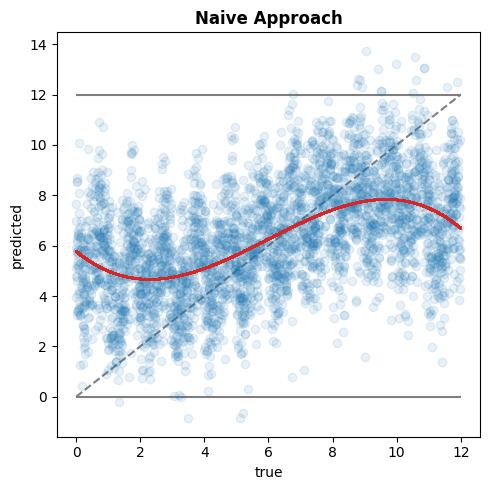

In [190]:
_, reg_y_test = get_regression_labels(y_train, y_test)
del _
naive_pred = get_predictions('nrg', X_test, reg_y_test)

x, y = naive_pred['true'], naive_pred['pred']
p = np.poly1d(np.polyfit(x, y, 3))

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, y, 'o', color='tab:blue', alpha=0.1, zorder=1)
ax.scatter(x, p(x), s=1, c='tab:red', zorder=2)
ax.plot([0, 12], [0, 12], '--', color='tab:gray', zorder=0)
ax.hlines(0, 0, 12, color='tab:gray', zorder=0)
ax.hlines(12, 0, 12, color='tab:gray', zorder=0)
ax.set_xlabel('true')
ax.set_ylabel('predicted')
ax.set_title('Naive Approach', weight='bold')
fig.tight_layout()
fig.savefig(DIRS['plots']+ 'nrg_acc.png', dpi=300)

2022-11-26 15:05:22.666916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 15:05:27.651711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 15:05:31.828012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


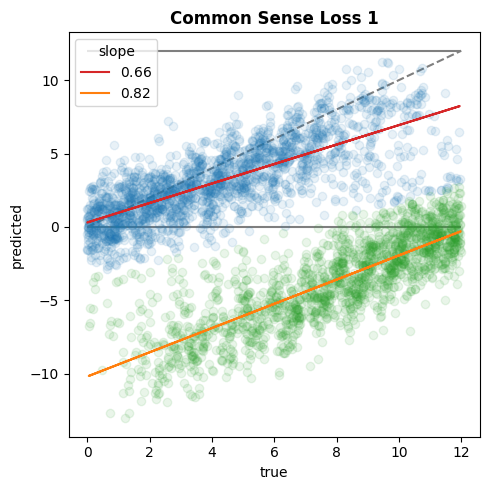

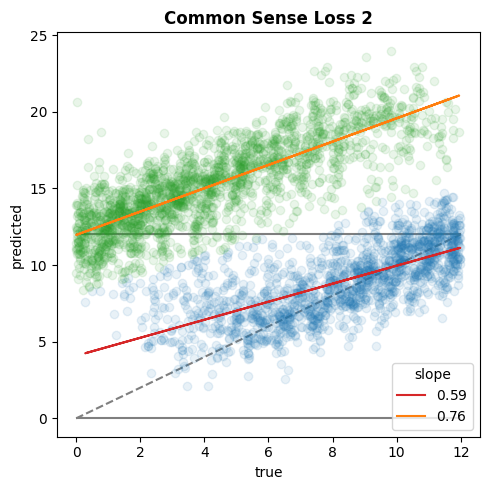

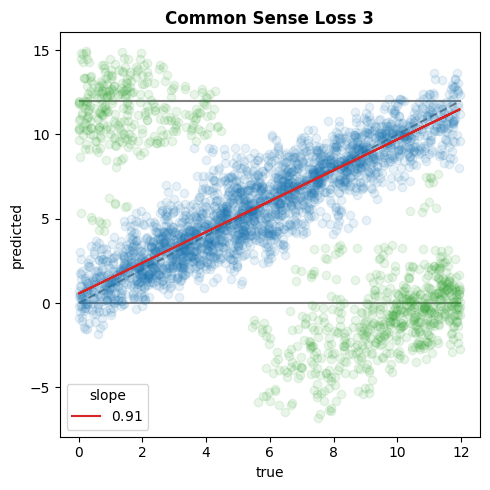

In [192]:
_, reg_y_test = get_regression_labels(y_train, y_test)
del _
for model_name in ['cs1', 'cs2', 'cs3']:
    pred = get_predictions(model_name, X_test, reg_y_test)
    method = 'dbscan' if model_name == 'cs3' else 'kmeans'
    clusters, slopes = get_clusters(pred, method=method)
    fig = get_scatterplot(clusters, slopes, title=model_name.replace('cs', 'Common Sense Loss '))
    fig.savefig(DIRS['plots'] + f'{model_name}_acc.png', dpi=500)